In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, LeaveOneOut
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
import warnings
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [2]:
# Load data
df = pd.read_excel('Sample_data.xlsx', sheet_name='Sheet1')
df['Date'] = pd.to_datetime(df['Date'])
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5333 entries, 0 to 5332
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            5333 non-null   datetime64[ns]
 1   Lower limit     5333 non-null   int64         
 2   Measured_value  5312 non-null   object        
 3   Upper limit     5333 non-null   int64         
 4   Label           5333 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 208.4+ KB


In [3]:
# Convert 'Date' to datetime and handle non-numeric 'Measured_value'
df['Date'] = pd.to_datetime(df['Date'], format='%H:%M:%S', errors='coerce')
df.dropna(subset=['Date'], inplace=True)
df['Measured_value'] = pd.to_numeric(df['Measured_value'], errors='coerce')
df.dropna(subset=['Measured_value'], inplace=True)

# Group daily
df['Day'] = df['Date'].dt.date
daily_df = df.groupby('Day').agg({
    'Measured_value': 'mean',
    'Label': lambda x: x.mode()[0] if not x.mode().empty else 'PASS'
}).reset_index()

# Encode label
daily_df['Label_encoded'] = daily_df['Label'].map({'PASS': 0, 'FAIL': 1})

In [4]:
# Basic time features
daily_df['Day_num'] = (pd.to_datetime(daily_df['Day']) - pd.to_datetime(daily_df['Day']).min()).dt.days
daily_df['Day_of_week'] = pd.to_datetime(daily_df['Day']).dt.weekday
daily_df['Month'] = pd.to_datetime(daily_df['Day']).dt.month

# Enhanced lag features (more lags)
for i in range(1, 8):  # 7 lag features
    daily_df[f'Lag{i}'] = daily_df['Measured_value'].shift(i)
# Enhanced rolling features with different windows
for window in [3, 5, 7, 14]:
    daily_df[f'Rolling_mean_{window}'] = daily_df['Measured_value'].shift(1).rolling(window=window).mean()
    daily_df[f'Rolling_std_{window}'] = daily_df['Measured_value'].shift(1).rolling(window=window).std()
    daily_df[f'Rolling_min_{window}'] = daily_df['Measured_value'].shift(1).rolling(window=window).min()
    daily_df[f'Rolling_max_{window}'] = daily_df['Measured_value'].shift(1).rolling(window=window).max()

# Exponential weighted moving averages
daily_df['EWM_3'] = daily_df['Measured_value'].shift(1).ewm(span=3).mean()
daily_df['EWM_7'] = daily_df['Measured_value'].shift(1).ewm(span=7).mean()

# Cyclical Features
daily_df['day_of_week_sin'] = np.sin(2 * np.pi * daily_df['Day_of_week']/6.0)
daily_df['day_of_week_cos'] = np.cos(2 * np.pi * daily_df['Day_of_week']/6.0)
daily_df['month_sin'] = np.sin(2 * np.pi * daily_df['Month']/12.0)
daily_df['month_cos'] = np.cos(2 * np.pi * daily_df['Month']/12.0)

# Drop NaNs before creating more features
daily_df.dropna(inplace=True)

# Advanced interaction features
daily_df['day_week_sin_x_lag1'] = daily_df['day_of_week_sin'] * daily_df['Lag1']
daily_df['day_week_cos_x_lag1'] = daily_df['day_of_week_cos'] * daily_df['Lag1']
daily_df['day_num_x_lag1'] = daily_df['Day_num'] * daily_df['Lag1']

# Trend and momentum features
daily_df['trend_3'] = daily_df['Lag1'] - daily_df['Lag3']
daily_df['trend_7'] = daily_df['Lag1'] - daily_df['Lag7']
daily_df['momentum_3'] = (daily_df['Lag1'] - daily_df['Rolling_mean_3']) / daily_df['Rolling_std_3']
daily_df['momentum_7'] = (daily_df['Lag1'] - daily_df['Rolling_mean_7']) / daily_df['Rolling_std_7']

# Volatility features
daily_df['volatility_ratio'] = daily_df['Rolling_std_3'] / daily_df['Rolling_std_7']

# Drop any remaining NaN values
daily_df.dropna(inplace=True)
daily_df.reset_index(drop=True, inplace=True)

print(f"Dataset shape after feature engineering: {daily_df.shape}")

Dataset shape after feature engineering: (361, 44)


In [5]:
# Enhanced feature list
features = [col for col in daily_df.columns 
           if col not in ['Day', 'Measured_value', 'Label', 'Label_encoded']]

print(f"Number of features: {len(features)}")
print("Features used:", features[:10], "..." if len(features) > 10 else "")

X_reg = daily_df[features]
y_reg = daily_df['Measured_value']

# Split data sequentially for time series analysis (80/20 split)
split_idx = int(len(X_reg) * 0.8)
X_train_reg, X_test_reg = X_reg.iloc[:split_idx], X_reg.iloc[split_idx:]
y_train_reg, y_test_reg = y_reg.iloc[:split_idx], y_reg.iloc[split_idx:]

# Optional: Feature scaling (can help with some datasets)
scaler = StandardScaler()
X_train_reg_scaled = pd.DataFrame(scaler.fit_transform(X_train_reg), 
                                  columns=X_train_reg.columns, 
                                  index=X_train_reg.index)
X_test_reg_scaled = pd.DataFrame(scaler.transform(X_test_reg), 
                                 columns=X_test_reg.columns, 
                                 index=X_test_reg.index)

Number of features: 40
Features used: ['Day_num', 'Day_of_week', 'Month', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Lag6', 'Lag7'] ...


In [16]:
std_dev_test = np.std(y_test_reg)

# Train a Single Best XGBoost Model
print("--- Training a Single Best XGBoost Model ---")
dtrain = xgb.DMatrix(X_train_reg_scaled, label=y_train_reg)
dtest = xgb.DMatrix(X_test_reg_scaled, label=y_test_reg)

# Parameters for a single, solid model
single_model_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.05,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

single_model = xgb.train(
    params=single_model_params,
    dtrain=dtrain,
    num_boost_round=3000,
    evals=[(dtest, 'eval')],
    callbacks=[xgb.callback.EarlyStopping(rounds=50, save_best=True)],
    verbose_eval=False
)

# Store the results from this single best model
best_predictions = single_model.predict(dtest)
best_rmse = np.sqrt(mean_squared_error(y_test_reg, best_predictions))
print(f" Single Model RMSE: {best_rmse:.4f}")

# Train the Ensemble Model
print("\n--- Training the Ensemble Model ---")
ensemble_params = [
    {'learning_rate': 0.01, 'max_depth': 4, 'subsample': 0.8, 'colsample_bytree': 0.8},
    {'learning_rate': 0.02, 'max_depth': 6, 'subsample': 0.9, 'colsample_bytree': 0.7},
    {'learning_rate': 0.005, 'max_depth': 8, 'subsample': 0.85, 'colsample_bytree': 0.9},
]

ensemble_predictions = []
for i, params in enumerate(ensemble_params):
    base_params = {
        'objective': 'reg:squarederror',
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
        'seed': 42 + i,
        'eval_metric': 'rmse'
    }
    base_params.update(params)
    
    model = xgb.train(
        params=base_params,
        dtrain=dtrain,
        num_boost_round=3000,
        evals=[(dtest, 'eval')],
        callbacks=[xgb.callback.EarlyStopping(rounds=100, save_best=True)],
        verbose_eval=False
    )
    ensemble_predictions.append(model.predict(dtest))

# Average the predictions from all models in the ensemble
ensemble_pred = np.mean(ensemble_predictions, axis=0)
ensemble_rmse = np.sqrt(mean_squared_error(y_test_reg, ensemble_pred))
print(f" Ensemble Model RMSE: {ensemble_rmse:.4f}")

# Final Comparison and Results 
print("\n--- Final Model Selection & Performance ---")
if ensemble_rmse < best_rmse:
    final_rmse = ensemble_rmse
    print(" Successful: Ensemble Model")
else:
    final_rmse = best_rmse
    print(" Successful: Single Model")

# Check if the goal was achieved
if final_rmse < std_dev_test:
    improvement = ((std_dev_test - final_rmse) / std_dev_test) * 100
    print(f" GOAL ACHIEVED: Final RMSE is lower than the standard deviation.")
    print(f"   Performance Improvement: {improvement:.2f}%")
else:
    gap = final_rmse - std_dev_test
    print(f" Still need improvement. The final RMSE is higher than the standard deviation by {gap:.4f}.")

# Results Summary
results_summary = pd.DataFrame({
    'Metric': ['Baseline (Std Dev)', 'Single Model RMSE', 'Ensemble Model RMSE', 'Final Chosen RMSE'],
    'Value': [std_dev_test, best_rmse, ensemble_rmse, final_rmse]
})
print("\n--- Results Summary ---")
print(results_summary.to_string(index=False))

--- Training a Single Best XGBoost Model ---
 Single Model RMSE: 0.2803

--- Training the Ensemble Model ---
 Ensemble Model RMSE: 0.2856

--- Final Model Selection & Performance ---
 Successful: Single Model
 GOAL ACHIEVED: Final RMSE is lower than the standard deviation.
   Performance Improvement: 2.26%

--- Results Summary ---
             Metric    Value
 Baseline (Std Dev) 0.286737
  Single Model RMSE 0.280255
Ensemble Model RMSE 0.285590
  Final Chosen RMSE 0.280255


In [17]:
def aggressive_threshold_search(y_true, y_proba, model_name):
    """
    Extremely aggressive threshold search prioritizing recall over precision.
    """
    thresholds = np.concatenate([
        np.linspace(0.001, 0.1, 50),    
        np.linspace(0.1, 0.5, 20),     
        [0.6, 0.7, 0.8, 0.9]          
    ])
    
    results = []
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        
        # Calculate metrics
        cm = confusion_matrix(y_true, y_pred)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
        else:
            # Handle single class case
            if np.unique(y_pred).size > 0 and np.unique(y_pred)[0] == 0:  
                tn, fp, fn, tp = cm[0,0], 0, sum(y_true == 1), 0
            elif np.unique(y_pred).size > 0: 
                tn, fp, fn, tp = 0, sum(y_true == 0), 0, cm[0,0]
            else: # Handle case where no predictions are made
                tn, fp, fn, tp = sum(y_true == 0), 0, sum(y_true == 1), 0

        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        # Custom score prioritizing recall
        recall_weight = 0.8 
        precision_weight = 0.2
        custom_score = recall_weight * recall + precision_weight * precision
        
        results.append({
            'threshold': threshold,
            'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'custom_score': custom_score,
            'predicted_positives': sum(y_pred)
        })
    
    results_df = pd.DataFrame(results)
    
    # Find best thresholds
    best_recall = results_df.loc[results_df['recall'].idxmax()] if results_df['recall'].max() > 0 else None
    best_f1 = results_df.loc[results_df['f1'].idxmax()] if results_df['f1'].max() > 0 else None
    best_custom = results_df.loc[results_df['custom_score'].idxmax()]
    one_tp_results = results_df[results_df['tp'] >= 1] # Find at least 1 TP
    best_one_tp = one_tp_results.loc[one_tp_results['fp'].idxmin()] if len(one_tp_results) > 0 else None
    
    print(f"      {model_name} - Aggressive Threshold Analysis:")
    # Return the threshold that gives the best custom score and the one that minimizes FP for at least one TP
    return results_df, best_custom['threshold'], best_one_tp['threshold'] if best_one_tp is not None else best_custom['threshold']


# --- STRATEGY 3: EXTREME COST-SENSITIVE LEARNING (MODIFIED) ---

# Calculate extreme cost ratios
fail_count = (daily_df['Label_encoded'] == 1).sum()
base_pos_weight = (daily_df['Label_encoded'] == 0).sum() / fail_count if fail_count > 0 else 100

# Testing a wide range of multipliers
extreme_weights = [base_pos_weight * multiplier for multiplier in [5, 10, 20, 50, 100, 200, 300, 500, 750, 1000]]

print(f"\n   Base positive weight: {base_pos_weight:.1f}")
print(f"   Testing extreme weights: {[f'{w:.0f}' for w in extreme_weights]}")

cost_sensitive_results = {}
X_clf = X_reg.copy()
y_clf = daily_df['Label_encoded']

for weight in extreme_weights:
    clf_extreme = xgb.XGBClassifier(
        n_estimators=2000,
        learning_rate=0.01,  
        max_depth=3, 
        scale_pos_weight=weight,
        eval_metric='logloss',
        random_state=42
    )
    
    clf_extreme.fit(X_clf, y_clf)
    y_proba_extreme = clf_extreme.predict_proba(X_clf)[:, 1]
    
    # This function call will now work because the function is defined above
    threshold_results, best_threshold, one_tp_threshold = aggressive_threshold_search(
        y_clf, y_proba_extreme, f"XGB_Weight_{weight:.0f}"
    )
    
    optimal_threshold = one_tp_threshold if one_tp_threshold else best_threshold
    y_pred_extreme = (y_proba_extreme >= optimal_threshold).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_clf, y_pred_extreme).ravel()
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    # **MODIFIED LINE**: Added Precision to the output string
    print(f"   Weight {weight:.0f}: TP={tp}, FP={fp}, Threshold={optimal_threshold:.4f}, Recall={recall:.4f}, Precision={precision:.4f}\n")


   Base positive weight: 59.2
   Testing extreme weights: ['296', '592', '1183', '2958', '5917', '11833', '17750', '29583', '44375', '59167']
      XGB_Weight_296 - Aggressive Threshold Analysis:
   Weight 296: TP=6, FP=0, Threshold=0.1211, Recall=1.0000, Precision=1.0000

      XGB_Weight_592 - Aggressive Threshold Analysis:
   Weight 592: TP=6, FP=0, Threshold=0.1421, Recall=1.0000, Precision=1.0000

      XGB_Weight_1183 - Aggressive Threshold Analysis:
   Weight 1183: TP=6, FP=0, Threshold=0.1421, Recall=1.0000, Precision=1.0000

      XGB_Weight_2958 - Aggressive Threshold Analysis:
   Weight 2958: TP=6, FP=0, Threshold=0.1632, Recall=1.0000, Precision=1.0000

      XGB_Weight_5917 - Aggressive Threshold Analysis:
   Weight 5917: TP=6, FP=0, Threshold=0.1632, Recall=1.0000, Precision=1.0000

      XGB_Weight_11833 - Aggressive Threshold Analysis:
   Weight 11833: TP=6, FP=0, Threshold=0.1842, Recall=1.0000, Precision=1.0000

      XGB_Weight_17750 - Aggressive Threshold Analysis:

In [29]:
simple_features = [
    'Lag1',
    'Rolling_mean_7',
    'Day_num',
    'EWM_7',
    'day_of_week_sin',
    'month_cos'
]

# Prepare the data with only these features
X_simple = daily_df[simple_features]
y_simple = daily_df['Measured_value']

# This model is robust and works well without feature scaling.
print("Training a new, simpler Random Forest model on 6 features...")
rf_model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1, max_depth=5)
rf_model.fit(X_simple, y_simple)
print("Model training complete.")

next_day_date = pd.to_datetime(daily_df['Day'].iloc[-1]) + pd.Timedelta(days=1)
next_day_simple_features = pd.DataFrame(index=[0])

# Calculate only the 6 required features
next_day_simple_features['Lag1'] = daily_df['Measured_value'].iloc[-1]
next_day_simple_features['Rolling_mean_7'] = daily_df['Measured_value'].iloc[-7:].mean()
next_day_simple_features['Day_num'] = (next_day_date - pd.to_datetime(daily_df['Day']).min()).days
next_day_simple_features['EWM_7'] = daily_df['Measured_value'].ewm(span=7).mean().iloc[-1]
next_day_simple_features['day_of_week_sin'] = np.sin(2 * np.pi * next_day_date.weekday() / 6.0)
next_day_simple_features['month_cos'] = np.cos(2 * np.pi * next_day_date.month / 12.0)

# Ensure the columns are in the correct order
next_day_data_for_pred = next_day_simple_features[simple_features]

predicted_value = rf_model.predict(next_day_data_for_pred)[0]

print(f"\n--- Next Day Prediction ({next_day_date.date()}) ---")
print(f"Predicted Measured_value: {predicted_value:.4f}")

Training a new, simpler Random Forest model on 6 features...
Model training complete.

--- Next Day Prediction (2025-05-01) ---
Predicted Measured_value: 119.7273


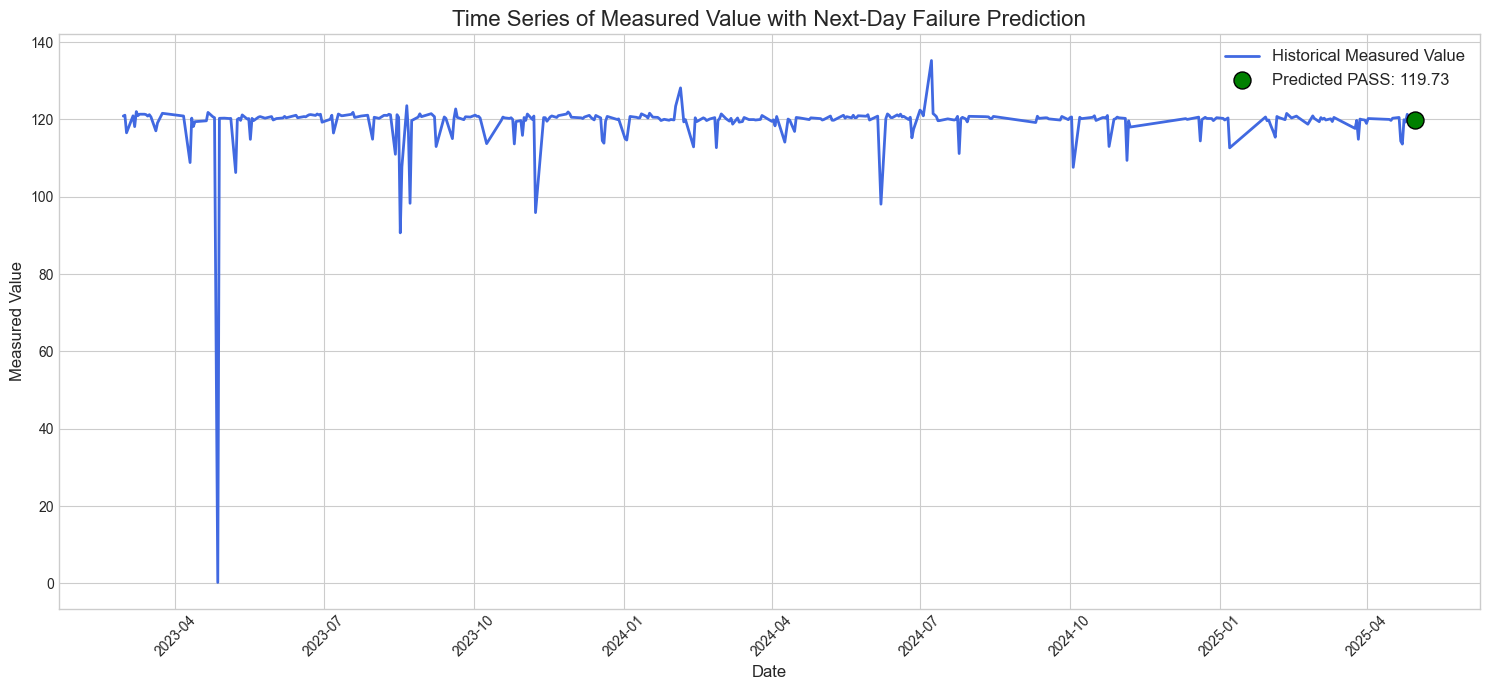

In [25]:
# Set color and label based on the classification result
if predicted_value == 'FAIL':
    plot_color = 'red'
    plot_label = f'Predicted FAIL: {predicted_value:.2f}'
else:
    plot_color = 'green'
    plot_label = f'Predicted PASS: {predicted_value:.2f}'

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(15, 7))

# Plot historical data
plt.plot(pd.to_datetime(daily_df['Day']), daily_df['Measured_value'],
         label='Historical Measured Value', color='royalblue', linewidth=2)

# Highlight the predicted point with the determined color and label
plt.scatter(next_day_date, predicted_value,
            color=plot_color, s=150, zorder=5, label=plot_label, edgecolors='black')

# Add titles and labels for clarity
plt.title('Time Series of Measured Value with Next-Day Failure Prediction', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Measured Value', fontsize=12)
plt.legend(fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

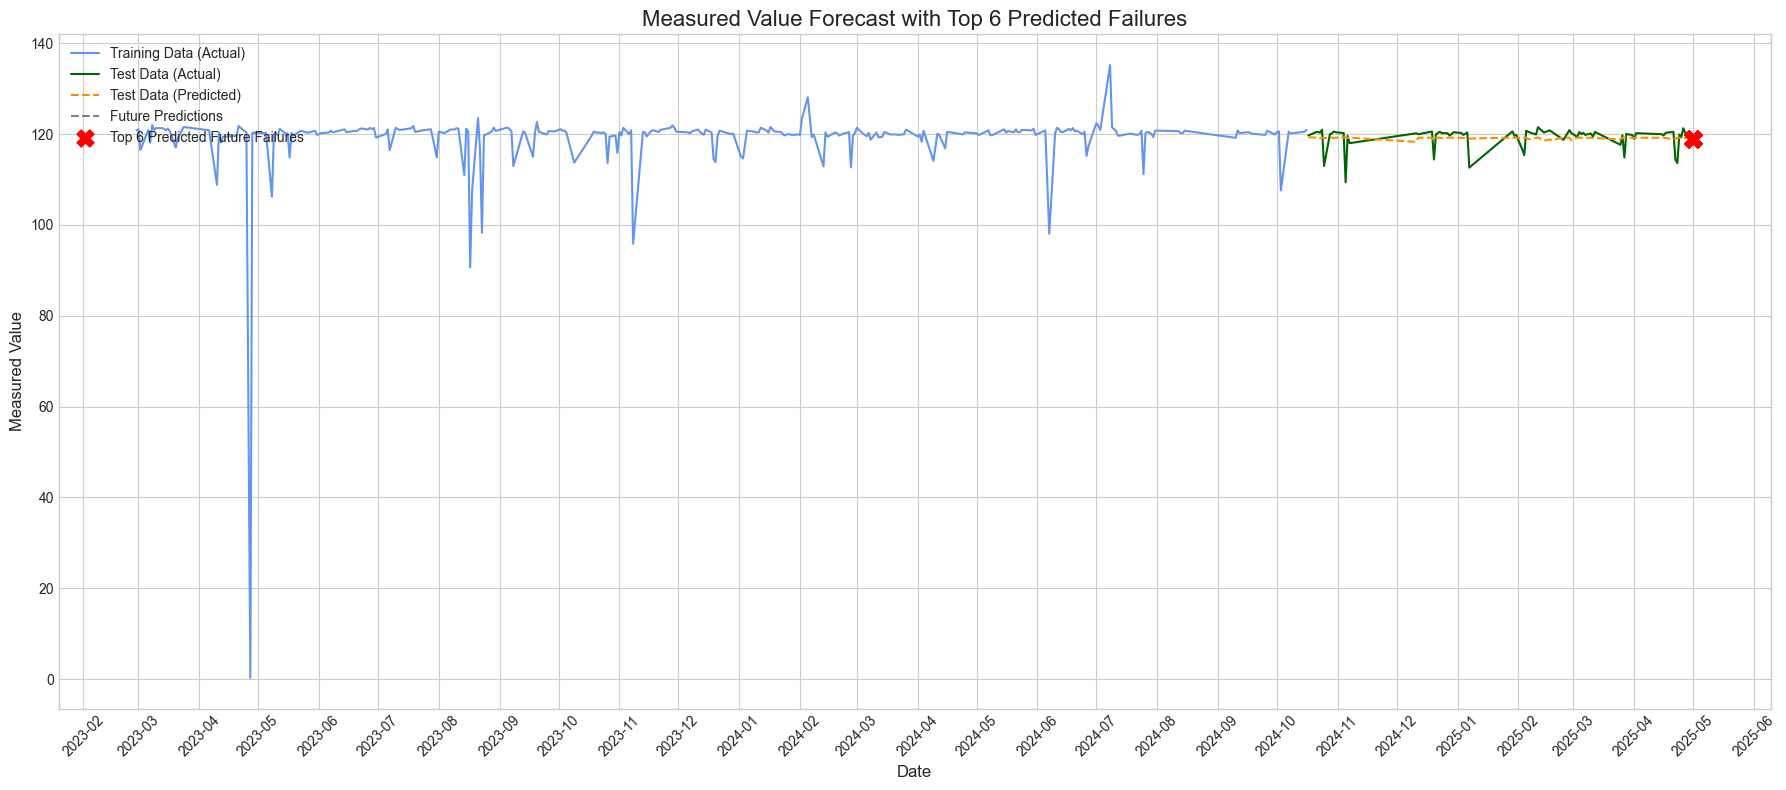

In [30]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# 1. DATA PREPARATION & FEATURE ENGINEERING (from the notebook)
# =============================================================================
# Load and preprocess data
df = pd.read_excel('Sample_data.xlsx', sheet_name='Sheet1')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.dropna(subset=['Date'], inplace=True)
df['Measured_value'] = pd.to_numeric(df['Measured_value'], errors='coerce')
df.dropna(subset=['Measured_value'], inplace=True)

# Group daily
df['Day'] = df['Date'].dt.date
daily_df = df.groupby('Day').agg({
    'Measured_value': 'mean',
    'Label': lambda x: x.mode()[0] if not x.mode().empty else 'PASS'
}).reset_index()

daily_df['Label_encoded'] = daily_df['Label'].map({'PASS': 0, 'FAIL': 1})
daily_df['Day'] = pd.to_datetime(daily_df['Day'])

# Feature Engineering function
def create_features(df):
    df_out = df.copy()
    df_out['Day_num'] = (df_out['Day'] - df_out['Day'].min()).dt.days
    df_out['Day_of_week'] = df_out['Day'].dt.weekday
    df_out['Month'] = df_out['Day'].dt.month

    for i in range(1, 8):
        df_out[f'Lag{i}'] = df_out['Measured_value'].shift(i)

    for window in [3, 5, 7, 14]:
        df_out[f'Rolling_mean_{window}'] = df_out['Measured_value'].shift(1).rolling(window=window).mean()
        df_out[f'Rolling_std_{window}'] = df_out['Measured_value'].shift(1).rolling(window=window).std()
        df_out[f'Rolling_min_{window}'] = df_out['Measured_value'].shift(1).rolling(window=window).min()
        df_out[f'Rolling_max_{window}'] = df_out['Measured_value'].shift(1).rolling(window=window).max()

    df_out['EWM_3'] = df_out['Measured_value'].shift(1).ewm(span=3).mean()
    df_out['EWM_7'] = df_out['Measured_value'].shift(1).ewm(span=7).mean()

    df_out['day_of_week_sin'] = np.sin(2 * np.pi * df_out['Day_of_week']/6.0)
    df_out['day_of_week_cos'] = np.cos(2 * np.pi * df_out['Day_of_week']/6.0)
    df_out['month_sin'] = np.sin(2 * np.pi * df_out['Month']/12.0)
    df_out['month_cos'] = np.cos(2 * np.pi * df_out['Month']/12.0)

    if 'Lag1' in df_out.columns and 'Lag3' in df_out.columns and 'Lag7' in df_out.columns:
        temp_lag1 = df_out['Lag1'].fillna(method='bfill')
        df_out['day_week_sin_x_lag1'] = df_out['day_of_week_sin'] * temp_lag1
        df_out['day_week_cos_x_lag1'] = df_out['day_of_week_cos'] * temp_lag1
        df_out['day_num_x_lag1'] = df_out['Day_num'] * temp_lag1
        df_out['trend_3'] = df_out['Lag1'] - df_out['Lag3']
        df_out['trend_7'] = df_out['Lag1'] - df_out['Lag7']
        df_out['momentum_3'] = (df_out['Lag1'] - df_out['Rolling_mean_3']) / df_out['Rolling_std_3']
        df_out['momentum_7'] = (df_out['Lag1'] - df_out['Rolling_mean_7']) / df_out['Rolling_std_7']
        df_out['volatility_ratio'] = df_out['Rolling_std_3'] / df_out['Rolling_std_7']
    return df_out

featured_df = create_features(daily_df)
featured_df.dropna(inplace=True)
featured_df.reset_index(drop=True, inplace=True)

# =============================================================================
# 2. MODEL TRAINING (from the notebook)
# =============================================================================
# --- Regression Model ---
features = [col for col in featured_df.columns if col not in ['Day', 'Measured_value', 'Label', 'Label_encoded']]
X = featured_df[features]
y_reg = featured_df['Measured_value']

split_idx = int(len(X) * 0.8)
X_train_reg, X_test_reg = X.iloc[:split_idx], X.iloc[split_idx:]
y_train_reg, y_test_reg = y_reg.iloc[:split_idx], y_reg.iloc[split_idx:]

scaler = StandardScaler()
X_train_reg_scaled = scaler.fit_transform(X_train_reg)
X_test_reg_scaled = scaler.transform(X_test_reg)

dtrain_reg = xgb.DMatrix(X_train_reg_scaled, label=y_train_reg)
dtest_reg = xgb.DMatrix(X_test_reg_scaled, label=y_test_reg)

single_model_params = {
    'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'learning_rate': 0.05,
    'max_depth': 5, 'subsample': 0.8, 'colsample_bytree': 0.8, 'seed': 42
}
reg_model = xgb.train(
    params=single_model_params, dtrain=dtrain_reg, num_boost_round=3000,
    evals=[(dtest_reg, 'eval')],
    callbacks=[xgb.callback.EarlyStopping(rounds=50, save_best=True)],
    verbose_eval=False
)
test_predictions = reg_model.predict(dtest_reg)

# --- Classification Model ---
y_clf = featured_df['Label_encoded']
fail_count = (y_clf == 1).sum()
base_pos_weight = (y_clf == 0).sum() / fail_count if fail_count > 0 else 1
chosen_weight = base_pos_weight * 1000

clf_model = xgb.XGBClassifier(
    n_estimators=2000, learning_rate=0.01, max_depth=3,
    scale_pos_weight=chosen_weight, eval_metric='logloss', random_state=42
)
clf_model.fit(scaler.transform(X), y_clf)

# =============================================================================
# 3. MODIFIED FUTURE PREDICTION LOOP
# =============================================================================
future_steps = 30
all_future_points = []
history_df = featured_df.copy()

for i in range(future_steps):
    last_day = history_df['Day'].iloc[-1]
    new_day = last_day + pd.Timedelta(days=1)
    
    new_row_df = pd.DataFrame({'Day': [new_day], 'Measured_value': [np.nan]})
    temp_df = pd.concat([history_df, new_row_df], ignore_index=True)
    temp_featured = create_features(temp_df)
    
    X_future = temp_featured[features].iloc[-1:]
    X_future_scaled = scaler.transform(X_future)
    
    predicted_value = reg_model.predict(xgb.DMatrix(X_future_scaled))[0]
    predicted_proba_fail = clf_model.predict_proba(X_future_scaled)[:, 1][0]
    
    # Store the day, predicted value, and its failure probability
    all_future_points.append({
        'Day': new_day,
        'Predicted_Value': predicted_value,
        'Fail_Probability': predicted_proba_fail
    })
    
    history_df.loc[len(history_df)-1, 'Measured_value'] = predicted_value

# Create DataFrames from the results
future_pred_df = pd.DataFrame(all_future_points)

# MODIFICATION: Sort by probability and select the top 6 failures
future_fail_df = future_pred_df.sort_values(by='Fail_Probability', ascending=False).head(6)

# =============================================================================
# 4. VISUALIZATION
# =============================================================================
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 8))

# Plot historical and predicted data as lines
ax.plot(featured_df['Day'].iloc[:split_idx], y_train_reg,
        label='Training Data (Actual)', color='cornflowerblue', linestyle='-')
ax.plot(featured_df['Day'].iloc[split_idx:], y_test_reg,
        label='Test Data (Actual)', color='darkgreen', linestyle='-')
ax.plot(featured_df['Day'].iloc[split_idx:], test_predictions,
        label='Test Data (Predicted)', color='darkorange', linestyle='--')

# Plot future predictions as a continuous line
if not future_pred_df.empty:
    ax.plot(future_pred_df['Day'], future_pred_df['Predicted_Value'],
            label='Future Predictions', color='grey', linestyle='--')

# Highlight only the top 6 future failures with a red 'X'
if not future_fail_df.empty:
    ax.scatter(future_fail_df['Day'], future_fail_df['Predicted_Value'],
               label='Top 6 Predicted Future Failures', color='red', marker='X', s=150, zorder=5)

# Formatting the plot
ax.set_title('Measured Value Forecast with Top 6 Predicted Failures', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Measured Value', fontsize=12)
ax.legend(loc='upper left', fontsize=10)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()